## requirements

In [1]:
import pandas as pd
import numpy as np
#pip install pandas-datareader
from pandas_datareader import data

from typing import List

## minimum variance model

The variance of a portfolio of financial assets will be minimized, yielding the percentage of ownership in each asset for a determined required level of return.

the algorithm is expressed below
$$ Min_{w_{i}}V_{p} \rightarrow L_{\left\{w_{i}\right\},\lambda_{1}\lambda_{2}}=\sum_{j=1}^n\sum_{j=1}^n w_{i}w_{j}+\lambda_{1}\left[ \sum_{i=1}^n w_{i}E\left(R_{i}\right)- E_{0}\right]+\lambda_{2}\left[ \sum_{i=1}^n w_{i}- 1\right] $$

$$ \frac{\partial L_{\left\{w_{i}\right\},\lambda_{1}\lambda_{2}}}{\partial w_{i}}=\sum_{j=1}^nw_{j}\sigma_{ij}+\lambda_{1}E\left(R_{i}\right)+\lambda_{2}=0 $$

$$ \frac{\partial L_{\left\{w_{i}\right\},\lambda_{1}\lambda_{2}}}{\partial \lambda_{1}}=\left[ \sum_{i=1}^n w_{i}E\left(R_{i}\right)- E_{0}\right]=0 $$

$$ \frac{\partial L_{\left\{w_{i}\right\},\lambda_{1}\lambda_{2}}}{\partial \lambda_{2}}=\left[ \sum_{i=1}^n w_{i}- 1\right] $$

$$ \begin{bmatrix}\left[2\sigma\right] & E\left(R\right) & 1 \\E\left(R\right) & 0 & 0 \\ 1 & 0 & 0\end{bmatrix}\begin{bmatrix}\left[W\right]  \\ \lambda_{1} \\ \lambda_{2} \end{bmatrix}=\begin{bmatrix}0  \\ E_{0} \\ 1 \end{bmatrix} $$

#### code

In [2]:
def rate(df):
    dfr = pd.DataFrame()
    for i in df.columns.values:
        dfr[f"{i}"] = df[f"{i}"] / df[f"{i}"].shift(1) - 1
    return dfr


def get_df(tikets:List[str],date:str)->dict:
    df = pd.DataFrame()
    invalid_tikets = []
    for i in tikets:
        try:
            df[f'{i}'] = data.DataReader(i,'yahoo',date)['Close']
        except:
            invalid_tikets.append(i)
    return {'dfr':rate(df),'df':df,'invalid_tikets':invalid_tikets}


In [3]:

def VM (R,dfr):
    vm_matrix=2*dfr.cov()
    vm_matrix["E(R)"]=dfr.mean()
    vm_matrix["w"]=1
    vm_matrix.loc[-2]=dfr.mean()
    vm_matrix.loc[-1]=1
    vm_matrix["w"][-2]=0
    vm_matrix["w"][-1]=0
    vm_matrix['E(R)'][-2]=0
    vm_matrix['E(R)'][-1]=0
    vm_matrix.rename(index={-2:'E(R)',-1:'w'}, inplace=True)
    vm_matrix_inv = pd.DataFrame(np.linalg.inv(vm_matrix.values), vm_matrix.columns, vm_matrix.index)
    vm_matrix_inv["w*"]=vm_matrix_inv["E(R)"]*(((1+R)**(1/252)-1))+vm_matrix_inv["w"]
    weight=vm_matrix_inv["w*"][:-2]
    return weight.to_dict()

In [4]:
close = get_df(['TSLA','GOOG','AAPL'],'2021-1-1')
VM(0.1,close['dfr'])

{'TSLA': 0.030818757409508124,
 'GOOG': 0.45457971293532934,
 'AAPL': 0.5146015296551625}

## Tree Regressor

#### Code

In [5]:

def get_df(tikets:List[str],date:str)->dict:
    df = pd.DataFrame()
    invalid_tikets = []
    for i in tikets:
        try:
            df[f'{i}'] = data.DataReader(i,'yahoo',date)['Close']
        except:
            invalid_tikets.append(i)
    return {'dfr':df,'df':df,'invalid_tikets':invalid_tikets}

def timeup(df,target:List[str],t:int=1):
    for tg in target:
        df[f'{tg}_{t}'] = df[f'{tg}'].shift(-t)
    return df

In [18]:
X_data = ['TSLA','GOOG','AAPL','EBAY','EA','AEP','BKNG','INTC']
close = get_df(X_data,'2020-1-1')

In [60]:
dfTree = close['dfr'].copy()
df_shift = timeup(dfTree,X_data,-3)
df_shift = timeup(dfTree,X_data,-2)
df_shift = timeup(dfTree,X_data,-1)
df_shift = timeup(dfTree,['EBAY'])
df_shift = df_shift.dropna()


In [61]:
df_shift.columns[0:-1]


Index(['TSLA', 'GOOG', 'AAPL', 'EBAY', 'EA', 'AEP', 'BKNG', 'INTC', 'TSLA_-3',
       'GOOG_-3', 'AAPL_-3', 'EBAY_-3', 'EA_-3', 'AEP_-3', 'BKNG_-3',
       'INTC_-3', 'TSLA_-2', 'GOOG_-2', 'AAPL_-2', 'EBAY_-2', 'EA_-2',
       'AEP_-2', 'BKNG_-2', 'INTC_-2', 'TSLA_-1', 'GOOG_-1', 'AAPL_-1',
       'EBAY_-1', 'EA_-1', 'AEP_-1', 'BKNG_-1', 'INTC_-1'],
      dtype='object')

doble segmentacion de datos

In [74]:
from sklearn.model_selection import train_test_split
X_train_dd, X_test_dd, y_train_dd, y_test_dd = train_test_split(df_shift[df_shift.columns[0:-1]],df_shift['EBAY_1'], test_size=0.2, shuffle=False)

X_train, X_test, y_train, y_test = train_test_split(X_train_dd,y_train_dd, test_size=0.2, shuffle=True)

In [75]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

alg = DecisionTreeRegressor(criterion='squared_error', max_depth=6)
alg.fit(X_train,y_train)
y_pred = alg.predict(X_test)
r2_score(y_test,y_pred)

0.9847335778190985

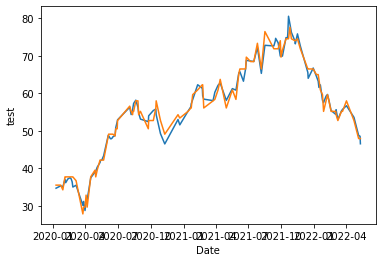

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

df_verification = pd.DataFrame()
df_verification['prediction']=y_pred
df_verification['test']=y_test.array
df_verification['Date']=y_test.index

fig, ax = plt.subplots()
ax= sns.lineplot(x='Date', y='test', data=df_verification)
ax1 = sns.lineplot(x='Date', y='prediction', data=df_verification)

In [77]:
y_pred_dd = alg.predict(X_test_dd)
r2_score(y_test_dd,y_pred_dd)

0.794192533557862

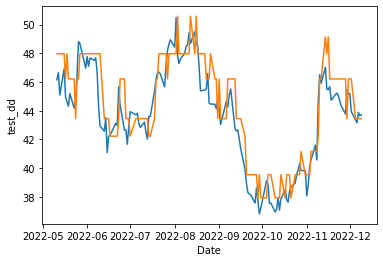

In [78]:
df_verification_dd = pd.DataFrame()
df_verification_dd['prediction_dd']=y_pred_dd
df_verification_dd['test_dd']=y_test_dd.array
df_verification_dd['Date']=y_test_dd.index
df_verification_dd
fig, ax = plt.subplots()
ax= sns.lineplot(x='Date', y='test_dd', data=df_verification_dd)
ax1 = sns.lineplot(x='Date', y='prediction_dd', data=df_verification_dd)



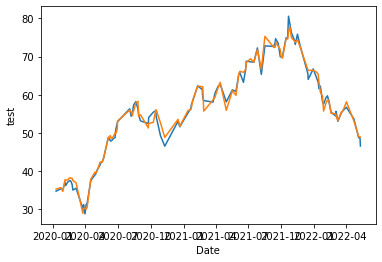

In [79]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=300, max_depth=8)

forest.fit(X_train,y_train)
y_pred = forest.predict(X_test)
r2_score(y_test,y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

df_verification = pd.DataFrame()
df_verification['prediction']=y_pred
df_verification['test']=y_test.array
df_verification['Date']=y_test.index

fig, ax = plt.subplots()
ax= sns.lineplot(x='Date', y='test', data=df_verification)
ax1 = sns.lineplot(x='Date', y='prediction', data=df_verification)

In [80]:
y_pred_dd = forest.predict(X_test_dd)
r2_score(y_test_dd,y_pred_dd)

0.5371051538883989

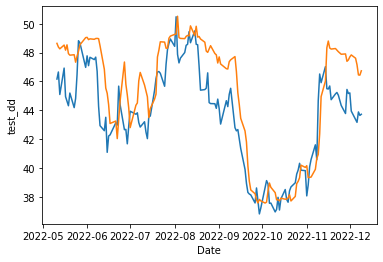

In [81]:
df_verification_dd = pd.DataFrame()
df_verification_dd['prediction_dd']=y_pred_dd
df_verification_dd['test_dd']=y_test_dd.array
df_verification_dd['Date']=y_test_dd.index
df_verification_dd
fig, ax = plt.subplots()
ax= sns.lineplot(x='Date', y='test_dd', data=df_verification_dd ,legend='auto')
ax1 = sns.lineplot(x='Date', y='prediction_dd', data=df_verification_dd ,legend='auto')


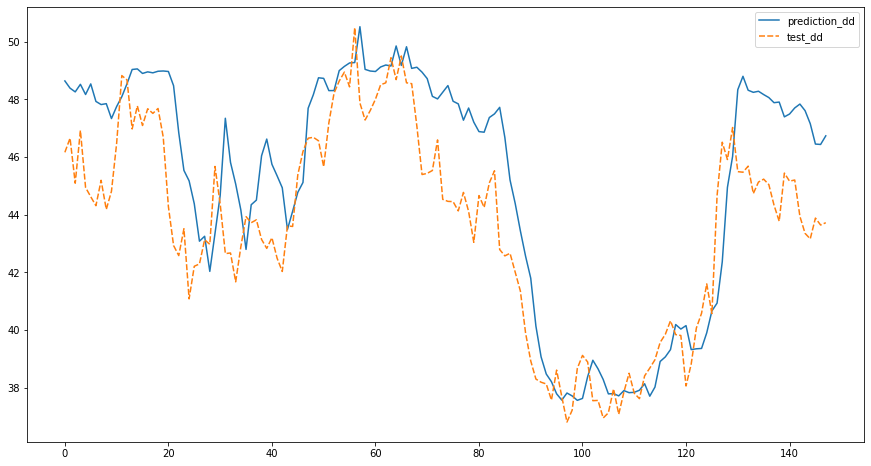

In [92]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))

plsns = sns.lineplot(data=df_verification_dd,legend='auto')